In [1]:
from google.colab import files
uploaded=files.upload()

Saving Emo_Data_polarity.csv to Emo_Data_polarity.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report

# Load data
Emo_Data_polarity = pd.read_csv('Emo_Data_polarity.csv')

print(Emo_Data_polarity.columns)
print('')
print(Emo_Data_polarity.shape)
print(Emo_Data_polarity.head())
print('')
Emo_Data_polarity.shape

Index(['Text', 'Emotion'], dtype='object')

(118961, 2)
                                                Text   Emotion
0                            i didnt feel humiliated  negative
1  i can go from feeling so hopeless to so damned...  negative
2   im grabbing a minute to post i feel greedy wrong  negative
3  i am ever feeling nostalgic about the fireplac...  positive
4                               i am feeling grouchy  negative



(118961, 2)

In [55]:
# Replacing intent text values to numerical
Emo_Data_polarity=Emo_Data_polarity.replace({"neutral":0,"negative":1,"positive":2, "ambiguous":3})
Emo_Data_polarity['Emotion'].unique()

array([1, 2, 3, 0])

In [4]:
# Split dataset into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(Emo_Data_polarity["Text"], Emo_Data_polarity["Emotion"],
                                                    test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((96357,), (10707,), (11897,), (96357,), (10707,), (11897,))

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
x_train_pad = tokenizer(x_train.tolist(), return_tensors='np', padding=True, truncation=True, max_length=170)
x_val_pad = tokenizer(x_val.tolist(), return_tensors='np', padding=True, truncation=True, max_length=170)
x_test_pad = tokenizer(x_test.tolist(), return_tensors='np', padding=True, truncation=True, max_length=170)

x_train_array = {key: x_train_pad[key] for key in x_train_pad}
x_val_array = {key: x_val_pad[key] for key in x_val_pad}
x_test_array={key: x_val_pad[key] for key in x_test_pad}

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
# One-hot-encode classes
n_classes = len(np.unique(y_train))
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

y_train_enc = tf.keras.utils.to_categorical(y_train_np, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val_np, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test_np, n_classes)

In [17]:
#datasets check
print(x_val_pad['input_ids'].shape)
print(y_val_enc.shape)
empty_sequences = np.sum(x_val_pad['input_ids'] == 0, axis=1) == 512
print(np.any(empty_sequences))
print(np.any(np.isnan(x_val_pad['input_ids'])))
print(np.any(np.isnan(y_val_enc)))

print(x_train_pad['input_ids'].shape)
print(y_train_enc.shape)
empty_sequences = np.sum(x_train_pad['input_ids'] == 0, axis=1) == 512
print(np.any(empty_sequences))
print(np.any(np.isnan(x_train_pad['input_ids'])))
print(np.any(np.isnan(y_train_enc)))

(10707, 98)
(10707, 4)
False
False
False
(96357, 170)
(96357, 4)
False
False
False


In [52]:
#Create model
from transformers import TFAutoModelForSequenceClassification

model_distilroberta = TFAutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=4)
for layer in model_distilroberta.layers[:-2]:
  layer.trainable = False

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
from tensorflow.keras.callbacks import EarlyStopping

#compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)]
model_distilroberta.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [54]:
# train model with callbacks.

history = model_distilroberta.fit(x_train_array, y_train_enc, batch_size=10, epochs=10,
                         validation_data=(x_val_array, y_val_enc), callbacks=[keras_callbacks])


Epoch 1/10
9636/9636 [==============================] - 762s 77ms/step - loss: 6.9022 - categorical_accuracy: 0.2116 - val_loss: 8.4693 - val_categorical_accuracy: 0.2628
Epoch 2/10
9636/9636 [==============================] - 728s 76ms/step - loss: 7.7615 - categorical_accuracy: 0.3429 - val_loss: 7.7361 - val_categorical_accuracy: 0.3406
Epoch 3/10
9636/9636 [==============================] - 727s 75ms/step - loss: 7.7951 - categorical_accuracy: 0.3465 - val_loss: 7.7361 - val_categorical_accuracy: 0.3406
Epoch 4/10
9636/9636 [==============================] - 728s 76ms/step - loss: 7.7820 - categorical_accuracy: 0.3465 - val_loss: 7.7361 - val_categorical_accuracy: 0.3406
Epoch 5/10
9636/9636 [==============================] - 730s 76ms/step - loss: 7.7927 - categorical_accuracy: 0.3464 - val_loss: 7.7361 - val_categorical_accuracy: 0.3406
Epoch 6/10
9636/9636 [==============================] - 727s 75ms/step - loss: 7.8073 - categorical_accuracy: 0.3464 - val_loss: 7.7361 - val_cat

In [56]:
x_test_array = {key: x_test_pad[key] for key in x_test_pad}

# Evaluate the model on the test data
score, acc = model_distilroberta.evaluate(x_test_array, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

372/372 [==============================] - 28s 66ms/step - loss: 7.9310 - categorical_accuracy: 0.3476
Test score: 7.931025981903076
Test accuracy: 0.3475666046142578


In [28]:
#y_pred = model_distilroberta.predict(x_test_array)
#y_pred

372/372 [==============================] - 25s 63ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[-0.9483047 ,  1.3929139 ,  1.2483528 , -1.1341728 ],
       [-0.9209889 ,  1.3618642 ,  1.2342052 , -1.1727791 ],
       [-0.94028205,  1.3858016 ,  1.2764689 , -1.1505018 ],
       ...,
       [-0.9118256 ,  1.3598329 ,  1.2658666 , -1.1082305 ],
       [-0.93010795,  1.4024785 ,  1.2450756 , -1.1533389 ],
       [-0.93101484,  1.358904  ,  1.2278925 , -1.113906  ]],
      dtype=float32), hidden_states=None, attentions=None)

In [57]:
#Classification report
y_pred = model_distilroberta.predict(x_test_array)
y_pred = y_pred.logits # Extract the logits
y_pred = tf.nn.softmax(y_pred) # Convert the logits to probabilities
y_pred_class = tf.argmax(y_pred, axis=1) # Get the class index with the highest probability for each sample
print(classification_report(y_test_np, y_pred_class.numpy()))

372/372 [==============================] - 25s 63ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2429
           1       0.35      1.00      0.52      4135
           2       0.00      0.00      0.00      4373
           3       0.00      0.00      0.00       960

    accuracy                           0.35     11897
   macro avg       0.09      0.25      0.13     11897
weighted avg       0.12      0.35      0.18     11897



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x1000 with 0 Axes>

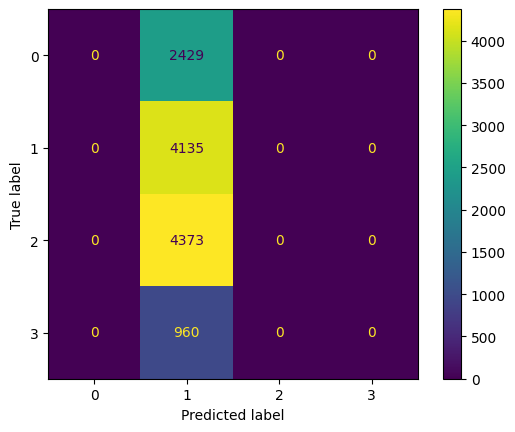

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_class)
unique_labels = np.unique(y_test_np)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

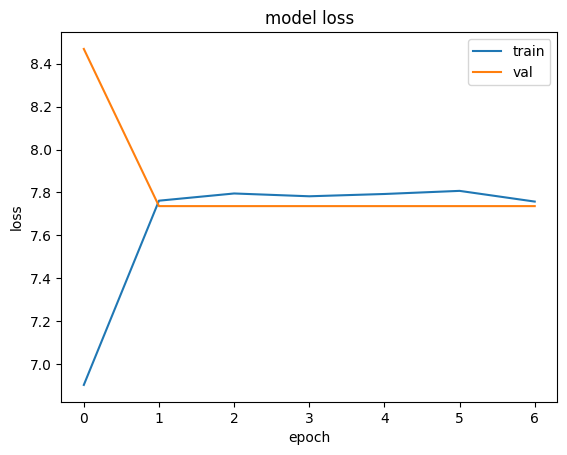

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

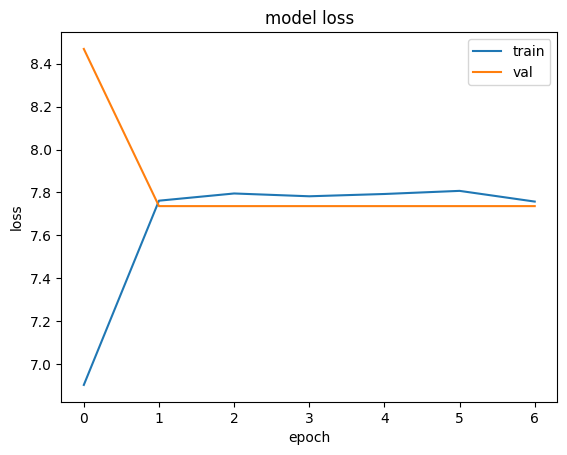

In [60]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()